In [1]:
# various import statements
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import pyro
import cuml

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")
    
import random

import sys
import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *
from antipode.antipode_mixins import AntipodeTrainingMixin, AntipodeSaveLoadMixin


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available
Number of GPUs: 1
GPU Name: NVIDIA A100-PCIE-40GB


In [2]:
model_tag='1.9.1.8.5_BG_longer'
out_path=os.path.join('/home/matthew.schmitz/Matthew/models/',model_tag)
batch_key='load_id'
discov_key='organism'
layer_key = None#'UMIs'
sex_key = 'self_reported_sex'
species_key = discov_key

In [3]:
# adata = sc.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/xspecies/BasalGanglia/HMBA_Human_Macaque_Marmoset_Mouse_snRNA-seq_BG_alignment_v6.h5ad")
# adata.obs['organism'] = adata.obs['organism'].cat.add_categories(['Mouse'])
# adata.obs.loc[adata.obs['organism'].isna(),"organism"] = "Mouse"
# adata.obs.loc[adata.obs['organism']=='Mouse',"self_reported_sex"] = adata.obs.loc[adata.obs['organism']=='Mouse',"sex"].astype(str).str.capitalize()
# adata.obs[batch_key] = adata.obs[batch_key].astype(str)
# adata.obs.loc[adata.obs['organism']=='Mouse',batch_key] = adata.obs.loc[adata.obs['organism']=='Mouse'].index.str.split('_').str[0]
# adata.obs[sex_key] = adata.obs[sex_key].astype(str)
# adata.obs.loc[adata.obs[species_key]=='Marmoset',sex_key] = adata.obs.loc[adata.obs[species_key]=='Marmoset','donor_id']
# adata.obs.loc[adata.obs[species_key]=='Marmoset',sex_key]
# adata.obs['donor_id'].replace({'cjCroissant':'Male','cjNutmeg':'Male','cjJellybean':'Female','cjRambo':'Female'})
# adata.obs[sex_key] = adata.obs[sex_key].replace({'cjCroissant':'Male','cjNutmeg':'Male','cjJellybean':'Female','cjRambo':'Female'}).astype('string')
# adata.obs[sex_key] = adata.obs[sex_key].astype('category')
# vcs = adata.obs.loc[adata.obs['organism']=='Mouse',batch_key].value_counts()
# adata.obs['self_reported_sex'] = adata.obs['self_reported_sex'].astype(str)
# adata.X = adata.layers['UMIs']
# del adata.layers['UMIs']
# adata.obs['log10_n_counts'] = np.log10(adata.X.sum(1))
# anndata.settings.allow_write_nullable_strings = True
# adata[~adata.obs[batch_key].isin(vcs.index[vcs<100]),:].write("/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/xspecies/BasalGanglia/HMBA_Human_Macaque_Marmoset_Mouse_snRNA-seq_BG_alignment_v7.h5ad")

In [4]:
adata = sc.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/xspecies/BasalGanglia/HMBA_Human_Macaque_Marmoset_Mouse_snRNA-seq_BG_alignment_v7.h5ad",backed='r')

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
adata.obs[sex_key] = adata.obs[sex_key].astype('category')
adata.obs[batch_key] = adata.obs[batch_key].astype('category')
adata.obs[batch_key] = adata.obs[batch_key].cat.remove_unused_categories()
# adata.obs['log10_n_counts'] = np.log10(adata.layers[layer_key].sum(1))
# chunk_size = 10000
# n_obs = adata.n_obs
# log10_n_counts = np.empty(n_obs, dtype=np.float32)

# for start in tqdm.tqdm(range(0, n_obs, chunk_size)):
#     end = min(start + chunk_size, n_obs)
#     X_chunk = adata.X[start:end].toarray() if hasattr(adata.X[start:end], "toarray") else adata.X[start:end]
#     log10_n_counts[start:end] = np.log10(X_chunk.sum(1))


In [6]:
adata.obsm['phase_sex']=np.concatenate([adata.obs['log10_n_counts'].to_numpy().reshape(-1,1),antipode.model_functions.numpy_onehot(adata.obs[sex_key].cat.codes)],axis=1)
# adata.obsm['phase_sex']=adata.obsm['phase_sex']/np.abs(adata.obsm['phase_sex']).max(0)#Scale so max value is magnitude 1
adata.obsm['phase_sex'] = adata.obsm['phase_sex'][:,0:4]
np.nan_to_num(adata.obsm['phase_sex'],copy=False,nan=0.)

species_aggr_means=antipode.model_functions.group_aggr_anndata(adata,[discov_key],layer=layer_key,normalize=True)
species_real_means=torch.tensor(species_aggr_means[0],requires_grad=False)
species_log_real_means=safe_log_transform(species_aggr_means[0]) # #species,#cluster,#genes array

 50%|█████     | 2/4 [11:02<11:02, 331.23s/it]

KeyboardInterrupt



In [8]:
try:
    del adata.uns['hvg']
except:
    pass
try:
    del adata.uns['neighbors']
except:
    pass

In [ ]:
adata

In [13]:
num_var=adata.shape[1]
batch_size=32
level_sizes=[1,75,600]
num_latent=200
steps=0
max_steps=[400000,200000,600000]
num_particles=3
print_every=5000

# Clear Pyro param store so we don't conflict with previous run
try:
    pyro.clear_param_store()
    del antipode_model
    torch.cuda.empty_cache()
except:
    pass
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(False)

# Instantiate instance of model/guide and various neural networks
antipode_model = ANTIPODE(num_latent=num_latent,level_sizes=level_sizes,seccov_key='phase_sex',bi_depth=2,num_batch_embed=3,psi_levels=[0.,0.,0.],
                adata=adata,discov_pair=('obs',discov_key),batch_pair=('obs',batch_key),layer=layer_key,min_theta=.1,
                use_psi=False,use_q_score=False,prior_scale=150.,theta_prior=25,sampler_category=species_key,dist_normalize=False,dcd_prior=torch.tensor(species_log_real_means,requires_grad=False).float(),
                scale_init_val=0.01,loc_as_param=False,zdw_as_param=False,intercept_as_param=False,seccov_as_param=True)

INFO     Generating sequential column names                                                                        


In [ ]:
antipode_model = antipode_model.run_standard_protocol(out_path,
                                     max_steps=max_steps,
                                     num_particles=num_particles,
                                     device=device,
                                     max_learning_rate=1e-3,
                                     one_cycle_lr=True,
                                     batch_size=batch_size,
                                     correction_steps=None)
adata = antipode_model.adata_manager.adata

last completed phase: 0
No checkpoints found. Starting training from scratch.
Running phase 1


  0%|          | 0/300000 [00:00<?, ?it/s]

fix scale factor


  0%|          | 1/300000 [00:21<1830:51:03, 21.97s/it]/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/train_utils.py:158: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/train_utils.py:161: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/allen/programs/celltypes/workgrou

In [7]:
antipode_model=ANTIPODE.load(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag),adata=adata,prefix='p3_',device=device)
adata=antipode_model.adata_manager.adata
antipode_model.store_outputs(device=device,prefix='')

INFO     Generating sequential column names                                                                        


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/pyro/params/param_store.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

INFO     Generating sequential column names                                                                        


100%|██████████| 1109/1109 [00:08<00:00, 135.82it/s]


In [8]:
!nvidia-smi
antipode_model.clear_cuda()
!nvidia-smi

Fri Oct 17 22:22:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.65.06              Driver Version: 580.65.06      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:B1:00.0 Off |                    0 |
| N/A   29C    P0             34W /  250W |    2459MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [18]:
MDE_KEY = "X_antipode_UMAP"
umap = cuml.UMAP(n_neighbors = 60,min_dist=0.2,spread=1,metric='manhattan',)
adata.obsm[MDE_KEY] = clip_latent_dimensions(umap.fit_transform(adata.obsm['X_antipode']),0.1)
np.savetxt(os.path.join(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag),MDE_KEY+'.csv'),adata.obsm[MDE_KEY],delimiter=',')
np.savetxt(os.path.join(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag),'X_antipode'+'.csv'),adata.obsm['X_antipode'],delimiter=',')

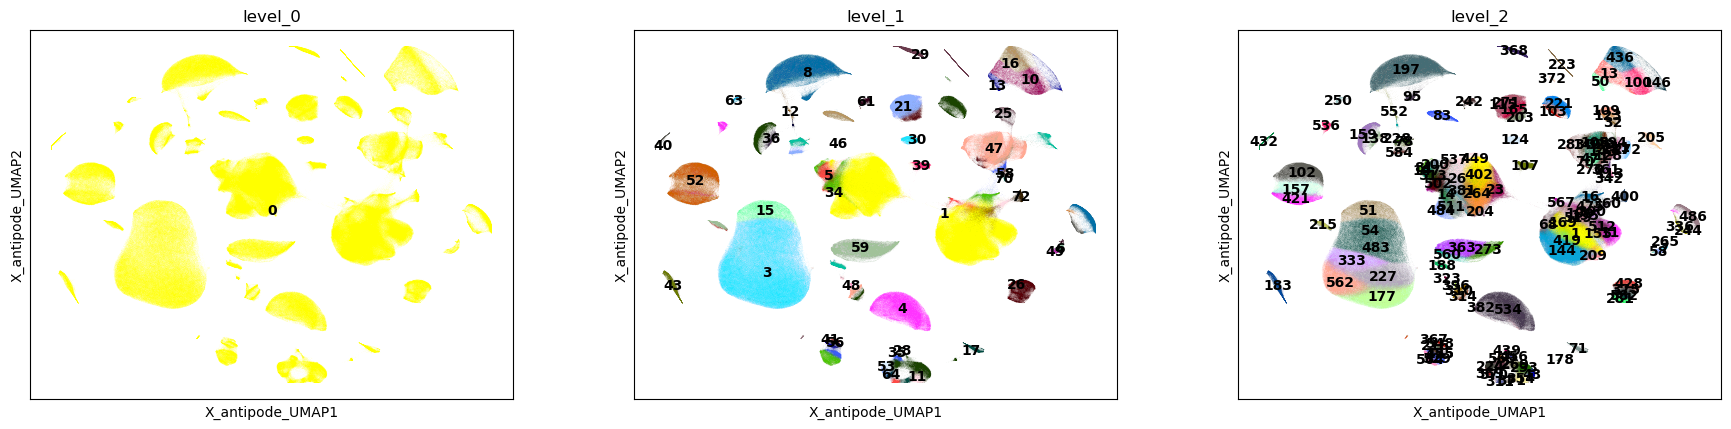

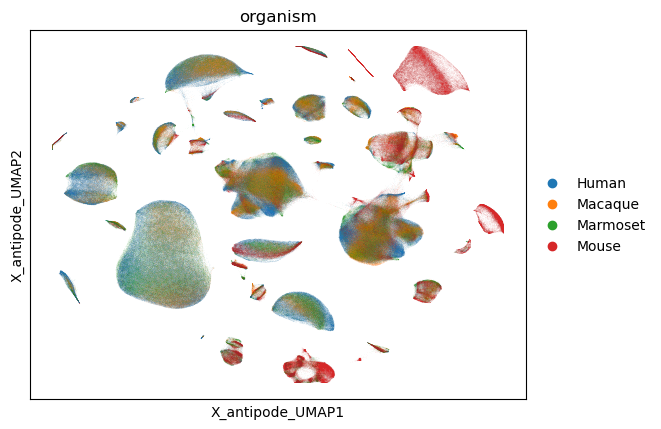

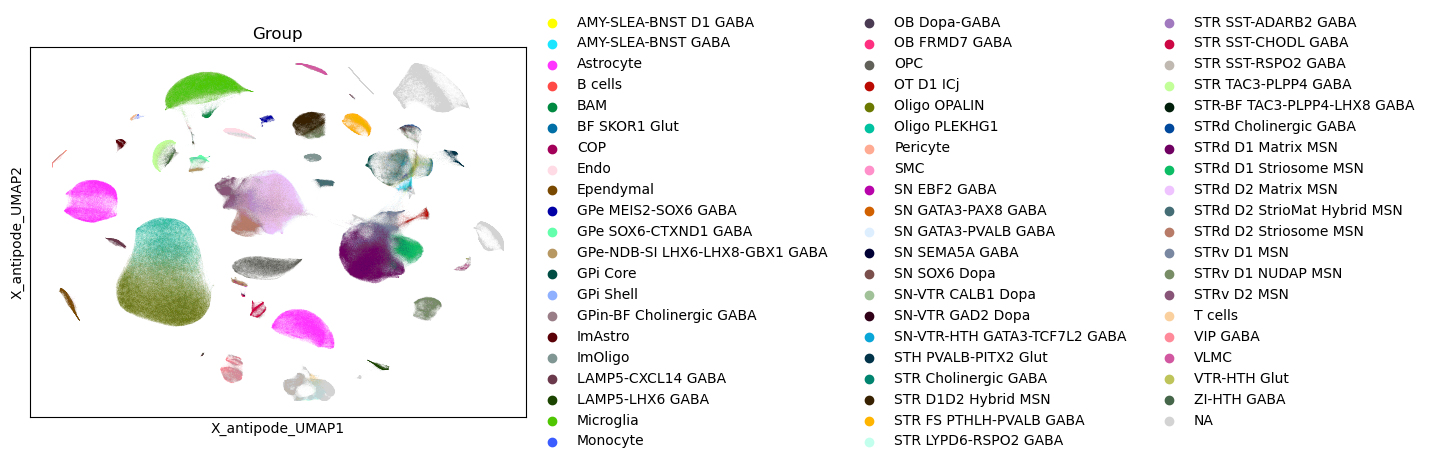

In [11]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'level' in x],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[discov_key]
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['Group']
)



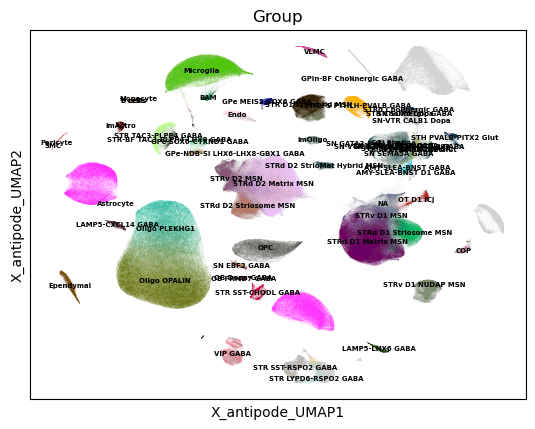

In [14]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['Group'],
    legend_loc='on data',
    legend_fontsize=5
)


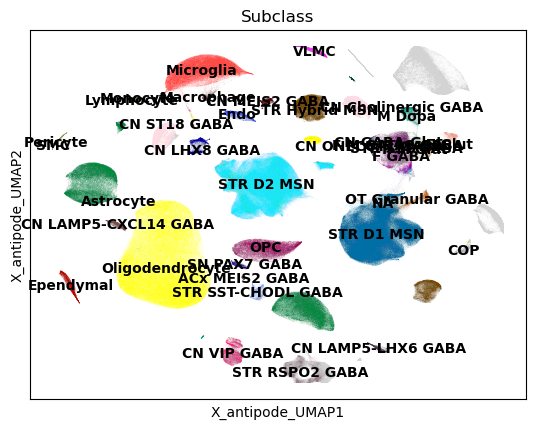

In [16]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['Subclass'],
    legend_loc='on data'
)


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


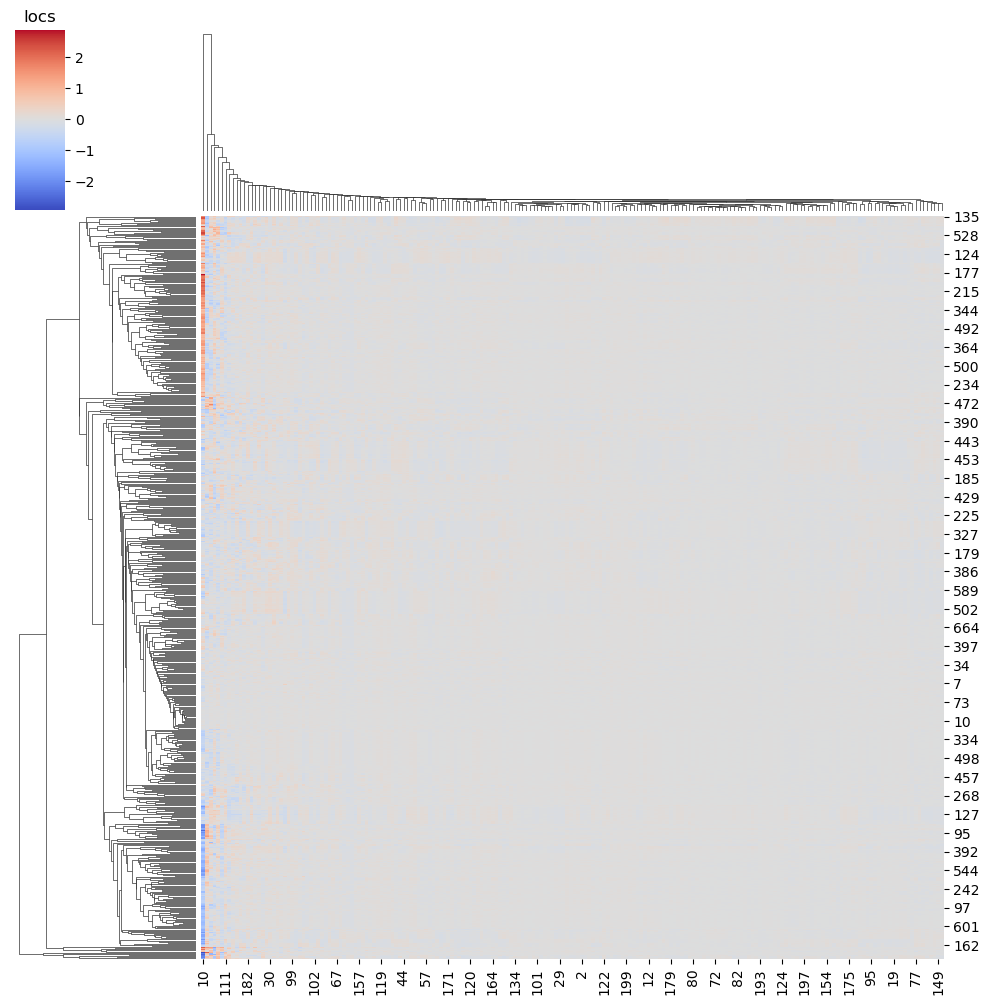

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


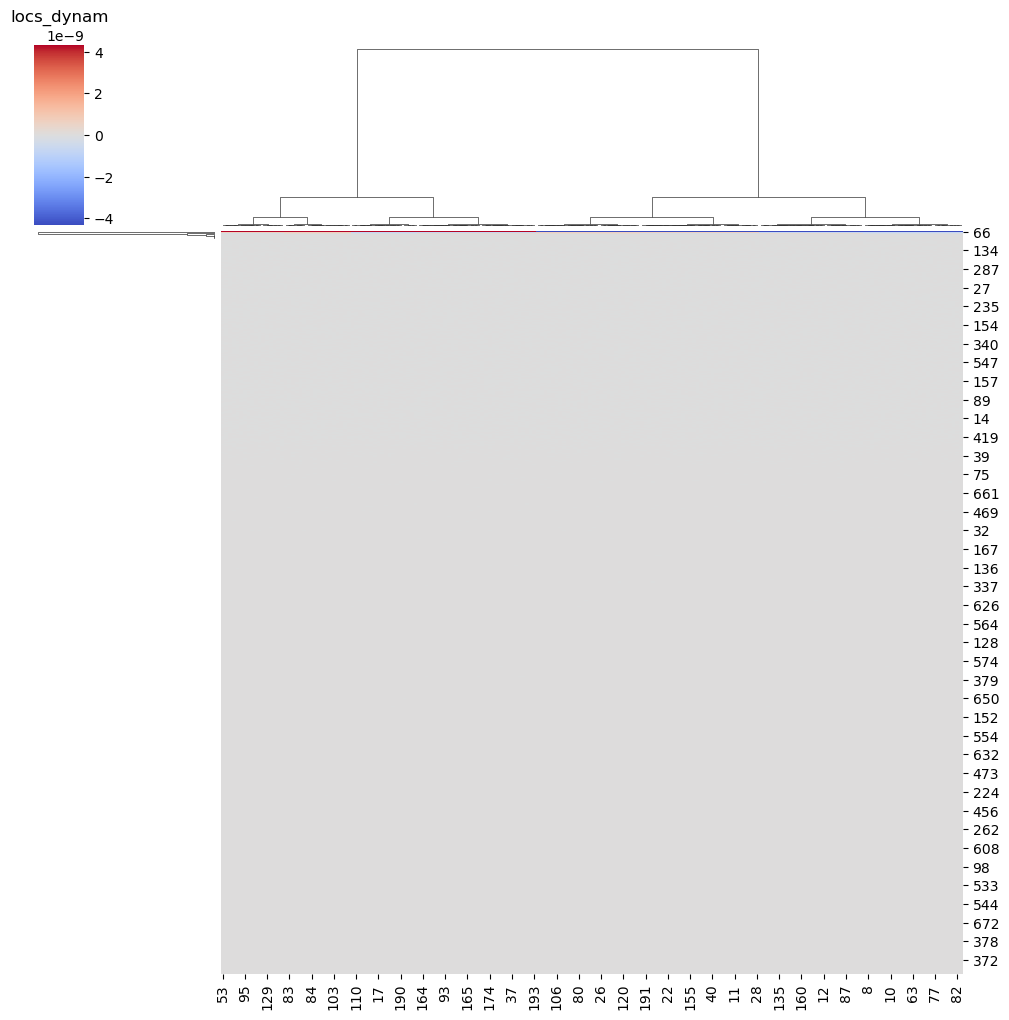

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


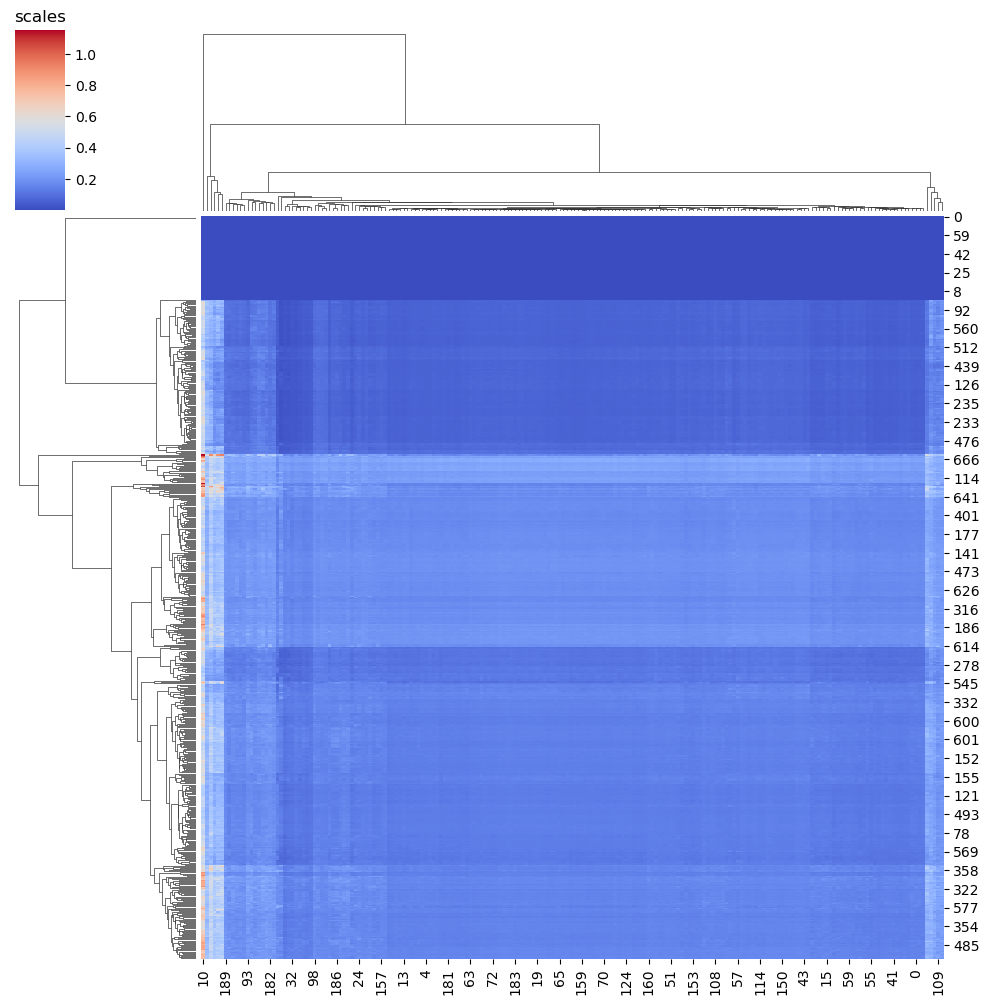

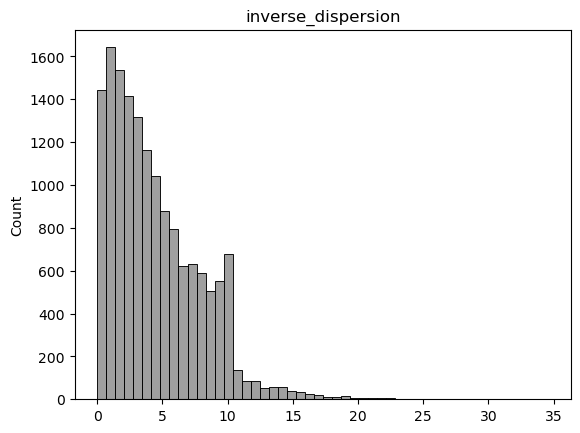

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


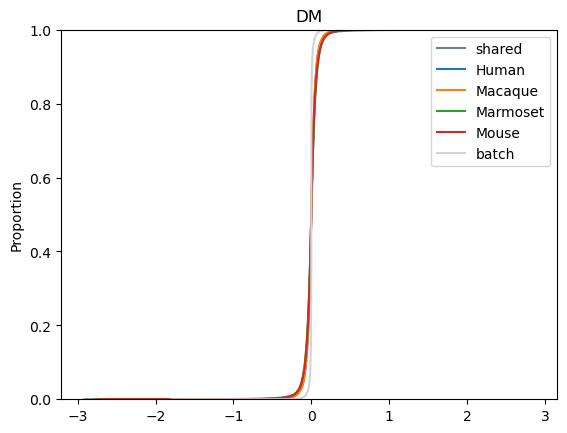

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


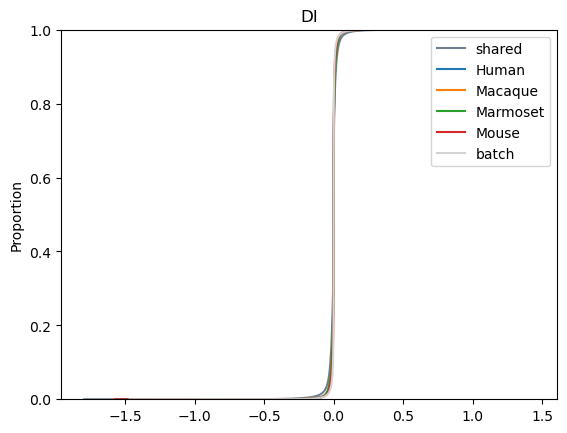

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


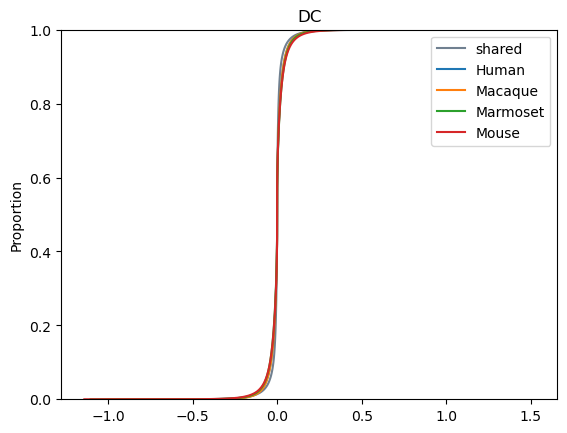

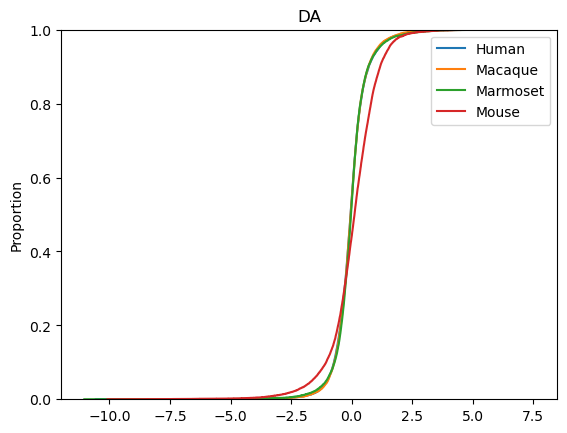

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/plotting.py:103: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(antipode_model.batch_key)[color_key]


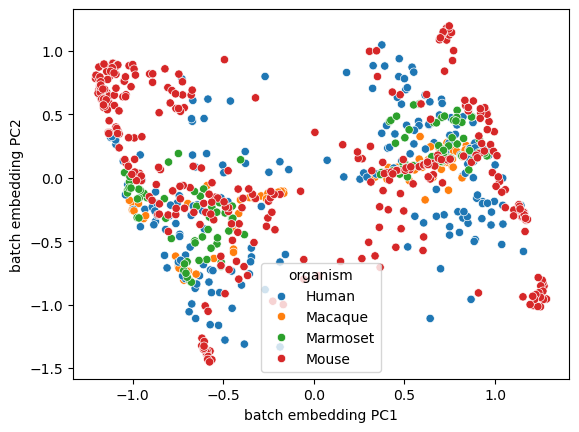

,0,1,load_id,organism
0,0.674075,0.119282,774_A06,Macaque
1,0.607066,0.117409,774_B06,Macaque
2,-0.167970,-0.104840,795.1_A06,Macaque
3,-0.695878,-0.202292,795.1_B06,Macaque
4,0.762822,0.214133,810_A02,Macaque
...,...,...,...,...
768,-0.949570,0.324145,pBICCNsMMrVISiF022d210719A2,Mouse
769,-1.022638,0.316494,pBICCNsMMrVISiF022d210719A3,Mouse
770,-0.621142,0.077420,pBICCNsMMrVISiM022d210719B1,Mouse
771,-0.562419,-0.038480,pBICCNsMMrVISiM022d210719B2,Mouse


In [17]:
# plot_loss(antipode_model.losses)
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model,ecdf=True)
plot_batch_embedding_pca(antipode_model)

In [ ]:
adata